# Mapping the temporal and spatial dynamics of the human endometrium in vivo and in vitro

### Identifying relative proportions of cell population specific mRNA contributing to endometrial and myometrial spots

## Libraries

In [1]:
import pandas as pd
import numpy as np
import anndata
import seaborn as sns
import scanpy as sc
import matplotlib.pyplot as plt
%matplotlib inline
import json
import cv2 # requires 'pip install opencv-python'

# custom script to plot spots that allows to zoom in
# do not import twice
import visium_plotting

In [2]:
np.random.seed(0)

In [3]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.4 scipy==1.3.2 pandas==0.25.3 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


### Defining paths to data

In [4]:
path = '/nfs/team292_visium_beta_phaseII/Sanger_PhaseII/new_data_20191209/Sanger_Visium_Beta_Phase_II_Manual_Align/'

# samples 152806 and 152810 are from donor A13 (Proliferative stage of the menstrual cycle)
# samples 152807 and 152811 are from donor A30 (Secretory stage of the menstrual cycle)

# sample IDs
IDs = ["152811", "152807", 
       "152810", "152806"]

In [5]:
# paths to objects

# objects with only spots under tissue, processed and analysed
analysed_object_paths = ['./data/adata_'+ID+'_spots_under_tissue_processed.h5ad' for ID in IDs]

# images provided by 10X Genomics
image_paths = [path + ID + '/' + ID + '_manual_spatial__tissue_hires_image.png' for ID in IDs]

# very high resolution in house images (exported from NDPI)
image_highest_res_paths = ['../data/' + ID + '_20x_highest_res_image.jpg' for ID in IDs]

# scale factors for spot coordinates
scalefactor_path = './scalefactors_dict.txt' 

## Reading data

In [6]:
%%time
images = {}
filtered_adatas = {}
scalefactors_dict = {}
images_highest_res = {}

for i in range(len(IDs)):
    
    images[IDs[i]] = cv2.imread(image_paths[i], -1)
    
    images_highest_res[IDs[i]] = cv2.imread(image_highest_res_paths[i], -1)
       
    filtered_adatas[IDs[i]] = sc.read(analysed_object_paths[i])

    
with open(scalefactor_path, 'r') as f:
    scalefactors_dict = json.load(f)


CPU times: user 26.3 s, sys: 28.6 s, total: 54.9 s
Wall time: 55 s


In [7]:
# objects were previously analysed in M3 notebook


def annot_endo_myo_152806(spot_id):
 
    curr_louvain = filtered_adatas['152806'].obs.loc[spot_id, 'clusters_louvain_0.6']
    
    if curr_louvain in [0,2,3]:
        return('endometrium')
    elif curr_louvain == 1:
        return('myometrium')
    
    else:
        return('outside_tissue')


def annot_endo_myo_152807(spot_id):
 
    curr_louvain = filtered_adatas['152807'].obs.loc[spot_id, 'clusters_louvain_0.5']
    
    if curr_louvain in [1,3]:
        return('endometrium')
    elif curr_louvain == 0:
        return('myometrium')
    elif curr_louvain == 2:
        return('excluding')
    
    else:
        return('outside_tissue')
    
    
    
def annot_endo_myo_152810(spot_id):
 
    curr_louvain = filtered_adatas['152810'].obs.loc[spot_id, 'clusters_louvain_0.3']
    
    if curr_louvain in [1,2,3]:
        return('endometrium')
    elif curr_louvain == 0:
        return('myometrium')
    
    else:
        return('outside_tissue')
    
    
    
    
def annot_endo_myo_152811(spot_id):
 
    curr_louvain = filtered_adatas['152811'].obs.loc[spot_id, 'clusters_louvain_0.7']
    
    if curr_louvain in [2,3]:
        return('endometrium')
    elif curr_louvain in [0,1]:
        return('myometrium')
    
    else:
        return('outside_tissue')


In [8]:
for ID in IDs:
    filtered_adatas[ID].obs['spot_id'] = filtered_adatas[ID].obs.index

In [9]:
filtered_adatas['152806'].obs['endo_myom_regions'] = filtered_adatas['152806'].obs['spot_id'].apply(lambda x: annot_endo_myo_152806(x))
filtered_adatas['152810'].obs['endo_myom_regions'] = filtered_adatas['152810'].obs['spot_id'].apply(lambda x: annot_endo_myo_152810(x))
filtered_adatas['152807'].obs['endo_myom_regions'] = filtered_adatas['152807'].obs['spot_id'].apply(lambda x: annot_endo_myo_152807(x))
filtered_adatas['152811'].obs['endo_myom_regions'] = filtered_adatas['152811'].obs['spot_id'].apply(lambda x: annot_endo_myo_152811(x))





In [10]:
for ID in IDs:
    print(ID)
    print(np.unique(filtered_adatas[ID].obs['endo_myom_regions'], return_counts=True))

152811
(array(['endometrium', 'myometrium'], dtype=object), array([1005, 2866]))
152807
(array(['endometrium', 'excluding', 'myometrium'], dtype=object), array([1118,  539, 1746]))
152810
(array(['endometrium', 'myometrium'], dtype=object), array([2320, 1686]))
152806
(array(['endometrium', 'myometrium'], dtype=object), array([2330, 1018]))


## Reading in Cell2location output

In [11]:
# reading cell2location output (csv tables of mRNA proportions for each cell cluster in a spot)
# for models trained on full objects (all genes), raw counts
# coarse grain annotation (Fig.1)

models_coarse_grain = {}

for ID in IDs:
    print(ID)
    path = '/nfs/team292/aa22/spatial_deconvolution_related/cell2location_std_models_20200610_all_sc/'
    
    if ID == '152806':
        folder = 'CoLocationModelNB4V2_13clusters_3348locations_19101genes_input_inferred_V4_batch1024_l2_0001_n_comb50_05_cps5_fpc3_short_all_sc_all_genes_152806/'
    if ID == '152810':
        folder = 'CoLocationModelNB4V2_13clusters_4008locations_19101genes_input_inferred_V4_batch1024_l2_0001_n_comb50_05_cps5_fpc3_short_all_sc_all_genes_152810/'
    if ID == '152807':
        folder = 'CoLocationModelNB4V2_13clusters_3403locations_19101genes_input_inferred_V4_batch1024_l2_0001_n_comb50_05_cps5_fpc3_short_all_sc_all_genes_152807/'
    if ID == '152811':
        folder = 'CoLocationModelNB4V2_13clusters_3871locations_19101genes_input_inferred_V4_batch1024_l2_0001_n_comb50_05_cps5_fpc3_short_all_sc_all_genes_152811/'
    
    
    models_coarse_grain[ID] = pd.read_csv(path+folder+'W_mRNA_count_q05.csv', 
                                                index_col=0)
    

152811
152807
152810
152806


In [13]:
models_coarse_grain['152806'].head()

,q05_nUMI_factorsNK,q05_nUMI_factorsPV_MYH11,q05_nUMI_factorsPV_STEAP4,q05_nUMI_factorsT_cells,q05_nUMI_factorsendo_arterial,q05_nUMI_factorsendo_lymphatic,q05_nUMI_factorsendo_velular,q05_nUMI_factorsepi,q05_nUMI_factorsepi_ciliated,q05_nUMI_factorsfibro_basal,q05_nUMI_factorsfibro_eS,q05_nUMI_factorsmyeloid,q05_nUMI_factorsuSMC
AAACAAGTATCTCCCA-1,59.918167,2.718451,0.747794,91.637810,20.836278,4.846844,627.519174,456.693759,68.352427,286.424945,663.203665,47.667070,514.180975
AAACAATCTACTAGCA-1,61.609175,0.558746,115.921179,35.485805,336.379846,108.595404,11.922907,896.723019,79.535683,3.310170,2349.045105,52.415150,17.979399
AAACAGAGCGACTCCT-1,2.869656,89.385748,1.192956,0.996920,4.420492,2.454446,389.397073,856.215198,324.329721,54.464534,216.106485,41.381502,0.713547
AAACATTTCCCGGATT-1,21.159241,5.850157,1.972560,22.187768,13.981828,1.696522,1148.926886,1420.582098,77.229970,409.475085,1157.281067,25.356479,114.735112
AAACCACTACACAGAT-1,5.522167,43.718370,0.293751,3.239193,0.643649,0.494174,102.544739,1.286822,0.038671,1.280203,80.300978,0.082227,212.771116


In [14]:
# renaming columns
# removing 'q05_nUMI_factorsNK'

for ID in IDs:
    print(ID)
    models_coarse_grain[ID].columns = ['coarse_'+elem[16:] for elem in list(models_coarse_grain[ID].columns)]


152811
152807
152810
152806


In [15]:
models_coarse_grain['152806'].head()

,coarse_NK,coarse_PV_MYH11,coarse_PV_STEAP4,coarse_T_cells,coarse_endo_arterial,coarse_endo_lymphatic,coarse_endo_velular,coarse_epi,coarse_epi_ciliated,coarse_fibro_basal,coarse_fibro_eS,coarse_myeloid,coarse_uSMC
AAACAAGTATCTCCCA-1,59.918167,2.718451,0.747794,91.637810,20.836278,4.846844,627.519174,456.693759,68.352427,286.424945,663.203665,47.667070,514.180975
AAACAATCTACTAGCA-1,61.609175,0.558746,115.921179,35.485805,336.379846,108.595404,11.922907,896.723019,79.535683,3.310170,2349.045105,52.415150,17.979399
AAACAGAGCGACTCCT-1,2.869656,89.385748,1.192956,0.996920,4.420492,2.454446,389.397073,856.215198,324.329721,54.464534,216.106485,41.381502,0.713547
AAACATTTCCCGGATT-1,21.159241,5.850157,1.972560,22.187768,13.981828,1.696522,1148.926886,1420.582098,77.229970,409.475085,1157.281067,25.356479,114.735112
AAACCACTACACAGAT-1,5.522167,43.718370,0.293751,3.239193,0.643649,0.494174,102.544739,1.286822,0.038671,1.280203,80.300978,0.082227,212.771116


In [23]:
filtered_adatas['152810']

AnnData object with n_obs × n_vars = 4006 × 33538 
    obs: 'Cluster', 'coarse_NK', 'coarse_PV_MYH11', 'coarse_PV_STEAP4', 'coarse_T_cells', 'coarse_endo_arterial', 'coarse_endo_lymphatic', 'coarse_endo_velular', 'coarse_epi', 'coarse_epi_ciliated', 'coarse_fibro_basal', 'coarse_fibro_eS', 'coarse_myeloid', 'coarse_uSMC', 'col', 'fine_NK', 'fine_PV_MYH11', 'fine_PV_STEAP4', 'fine_T_cell', 'fine_endo_arterial', 'fine_endo_lymphatic', 'fine_endo_venular', 'fine_epithelial_CLU_1', 'fine_epithelial_CLU_2', 'fine_epithelial_LGR5', 'fine_epithelial_LYPD1', 'fine_epithelial_ciliated', 'fine_epithelial_glandular', 'fine_epithelial_proliferative', 'fine_fibro_2', 'fine_fibro_eS', 'fine_myeloid', 'fine_uSMC', 'imagecol', 'imagerow', 'log_counts', 'n_counts', 'n_genes', 'percent_mito', 'row', 'sample_ID', 'tissue', 'x_high_10X', 'x_highest_adj', 'x_highest_not_adj', 'y_high_10X', 'y_highest_adj', 'y_highest_not_adj', 'clusters_louvain_0.3', 'x_sel', 'y_sel', 'spot_id', 'endo_myom_regions'
    var

In [20]:
models_coarse_grain['152810'].shape

(4008, 13)

In [24]:
# adding cell2location results to the filtered_adatas objects

for ID in IDs:
    print(ID)
    # coarse grain
    filtered_adatas[ID].obs = filtered_adatas[ID].obs.combine_first(models_coarse_grain[ID].loc[filtered_adatas[ID].obs.index,:])

152811
152807
152810
152806


## Barplots of proportions of mRNA contributing to each region (endometrium or myometrium)

In [27]:
target_col = 'endo_myom_regions'

clus_means = {}


for ID in IDs:
    print(ID)
    
    cell_types_here = list(set(filtered_adatas[ID].obs.columns) & set(models_coarse_grain[ID].columns))
    
    clus_means[ID] = pd.DataFrame(index = cell_types_here,
                                  columns=['endometrium','myometrium'])
    
    cluster_vecs = {}
    for clus in ['endometrium','myometrium']:
        print(clus)
        cluster_vecs[clus] = filtered_adatas[ID].obs[filtered_adatas[ID].obs[target_col] == clus]
        
        # this will be total mRNA contribution of each cluster to this regions' spots
        cluster_vecs[clus] = cluster_vecs[clus].loc[:,cell_types_here].sum(axis=0)
        
        # normalising by the total mRNA counts from all cell clusters to obtain proportions
        cluster_vecs[clus] = cluster_vecs[clus]
        
        clus_means[ID][clus] = cluster_vecs[clus]
        print('len of current added column',
              len(clus_means[ID][clus]))
    
    # do this if you want to have per regions bars
    #clus_means[ID] = clus_means[ID].T
    
    # normalise by row (each cell type's proportions in endo vs myom)
    clus_means[ID] = clus_means[ID].div(clus_means[ID].sum(axis=1), axis=0)
    
    
    # dropping old rows with separate cell populations
    #clus_means[ID] = clus_means[ID].drop(epi_index+fibro_index, axis=0)
    

152811
endometrium
len of current added column 13
myometrium
len of current added column 13
152807
endometrium
len of current added column 13
myometrium
len of current added column 13
152810
endometrium
len of current added column 13
myometrium
len of current added column 13
152806
endometrium
len of current added column 13
myometrium
len of current added column 13


In [29]:
clus_means['152806']

,endometrium,myometrium
coarse_NK,0.967228,0.032772
coarse_fibro_eS,0.953843,0.046157
coarse_endo_arterial,0.968702,0.031298
coarse_epi,0.942002,0.057998
coarse_PV_STEAP4,0.983801,0.016199
coarse_fibro_basal,0.862226,0.137774
coarse_myeloid,0.940943,0.059057
coarse_endo_velular,0.845351,0.154649
coarse_PV_MYH11,0.550959,0.449041
coarse_epi_ciliated,0.931043,0.068957


In [30]:
list(clus_means['152811'].columns)

['endometrium', 'myometrium']

In [38]:
# changing the order of cell types
rows_new_order = ['uSMC','PV_MYH11',
                  'endo_velular', # endo_venular, typo
                  'endo_arterial',
                  'endo_lymphatic','PV_STEAP4','fibro_basal',
                  'fibro_eS','epi','epi_ciliated',
                  'myeloid','T_cells','NK']

rows_new_order = ['coarse_'+elem for elem in rows_new_order]



In [39]:
len(set(clus_means['152811'].index) & set(rows_new_order))

13

In [40]:
for ID in IDs:
    clus_means[ID] = clus_means[ID].loc[rows_new_order,:]

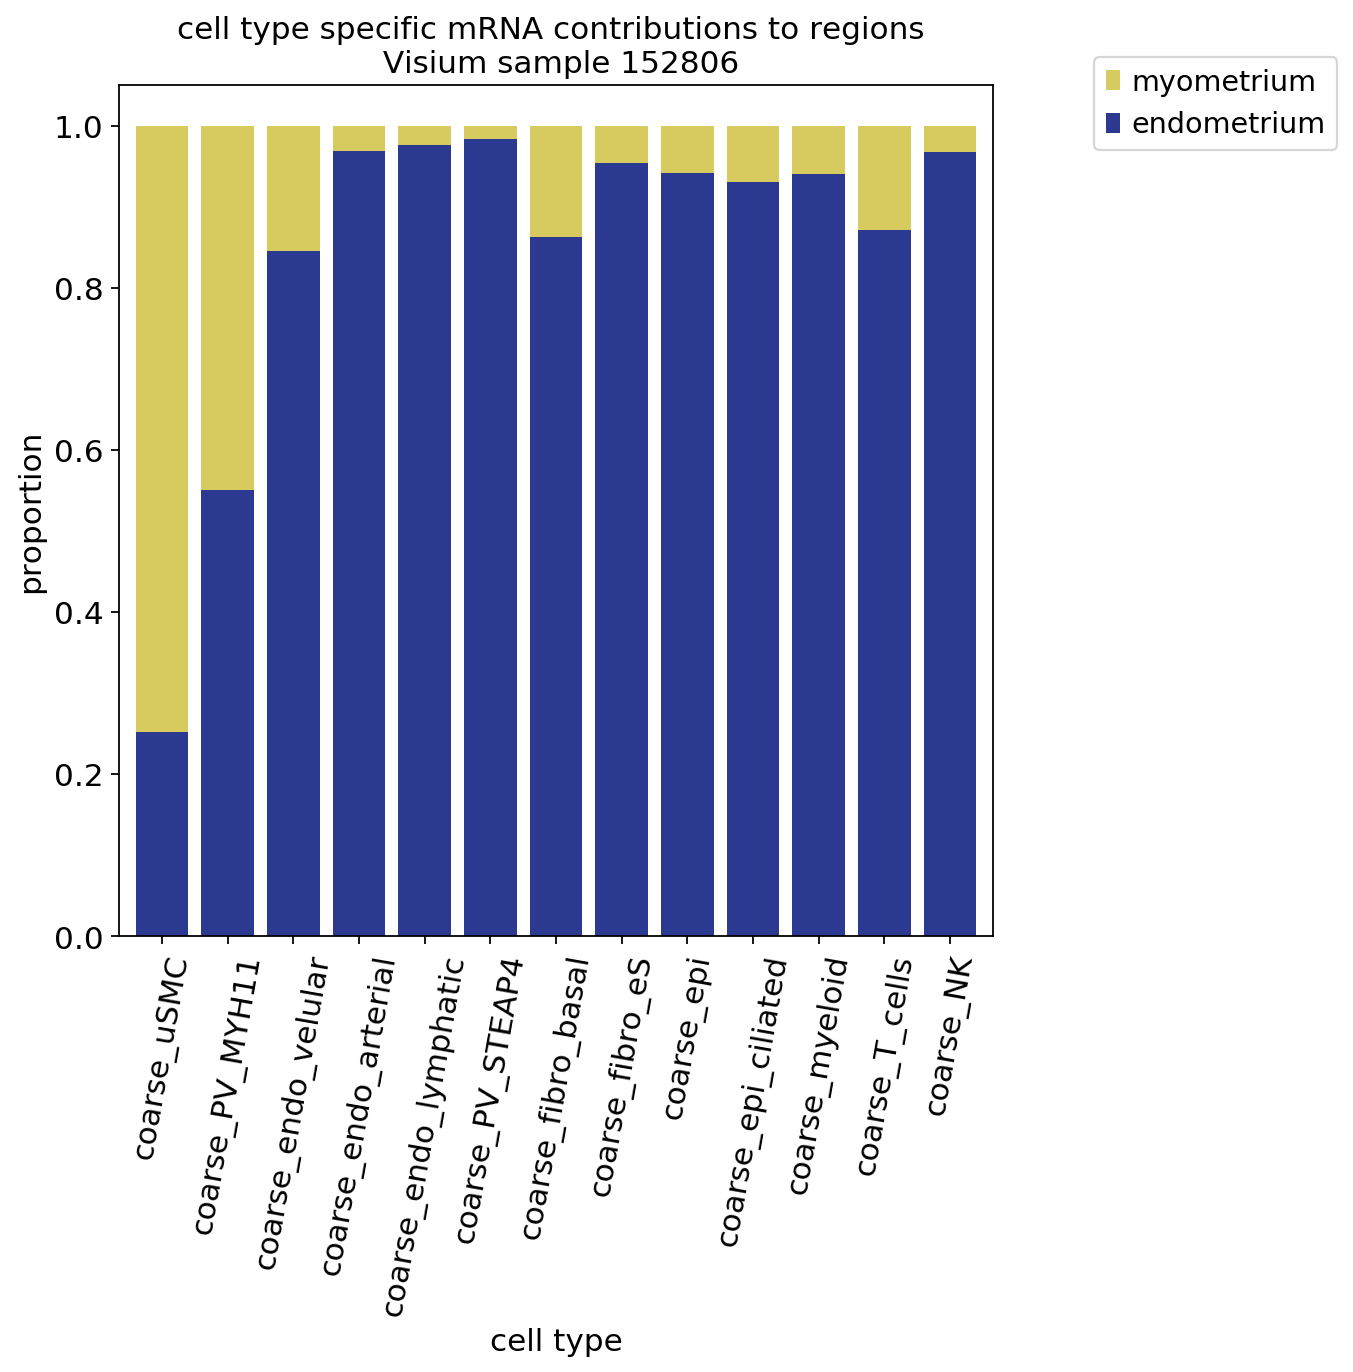

In [42]:
ax = clus_means['152806'].plot.bar(stacked=True, figsize=(7,7), width=0.8,
                                  color=('#2B3990','#D7CB60'))
#plt.legend()
handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles[::-1], labels[::-1], title='Line', loc='upper left')
ax.legend(handles[::-1],labels[::-1],
          bbox_to_anchor=(1.1, 1.05))
ax.tick_params(axis='x', rotation=80)

# to turn off the grid
plt.grid(b=None)

plt.title('cell type specific mRNA contributions to regions \n Visium sample 152806')
plt.ylabel('proportion')
plt.xlabel('cell type')

plt.savefig('./figures/Proportion_plots/152806_ct_mRNA_proportions_coarse_endo_myo.pdf',
           bbox_inches='tight')

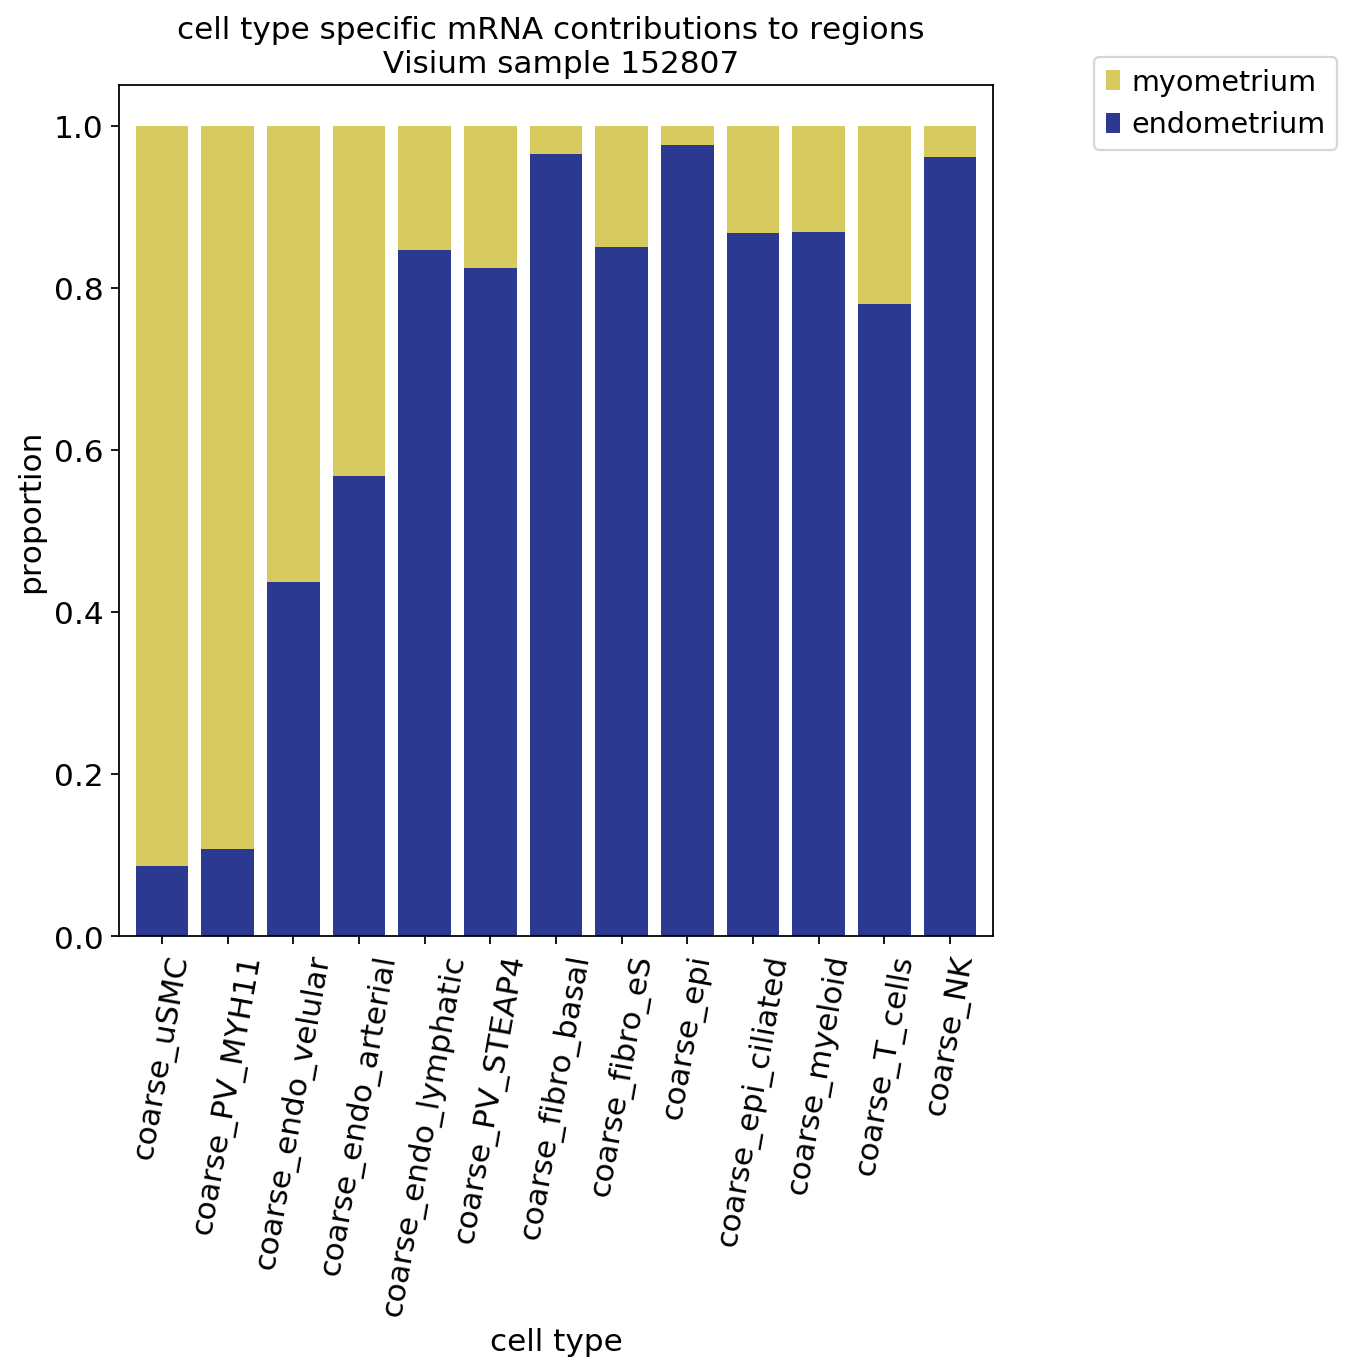

In [43]:
ax = clus_means['152807'].plot.bar(stacked=True, figsize=(7,7), width=0.8,
                                  color=('#2B3990','#D7CB60'))
#plt.legend()
handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles[::-1], labels[::-1], title='Line', loc='upper left')
ax.legend(handles[::-1],labels[::-1],
          bbox_to_anchor=(1.1, 1.05))
ax.tick_params(axis='x', rotation=80)

# to turn off the grid
plt.grid(b=None)

plt.title('cell type specific mRNA contributions to regions \n Visium sample 152807')
plt.ylabel('proportion')
plt.xlabel('cell type')

plt.savefig('./figures/Proportion_plots/152807_ct_mRNA_proportions_coarse_endo_myo.pdf',
           bbox_inches='tight')

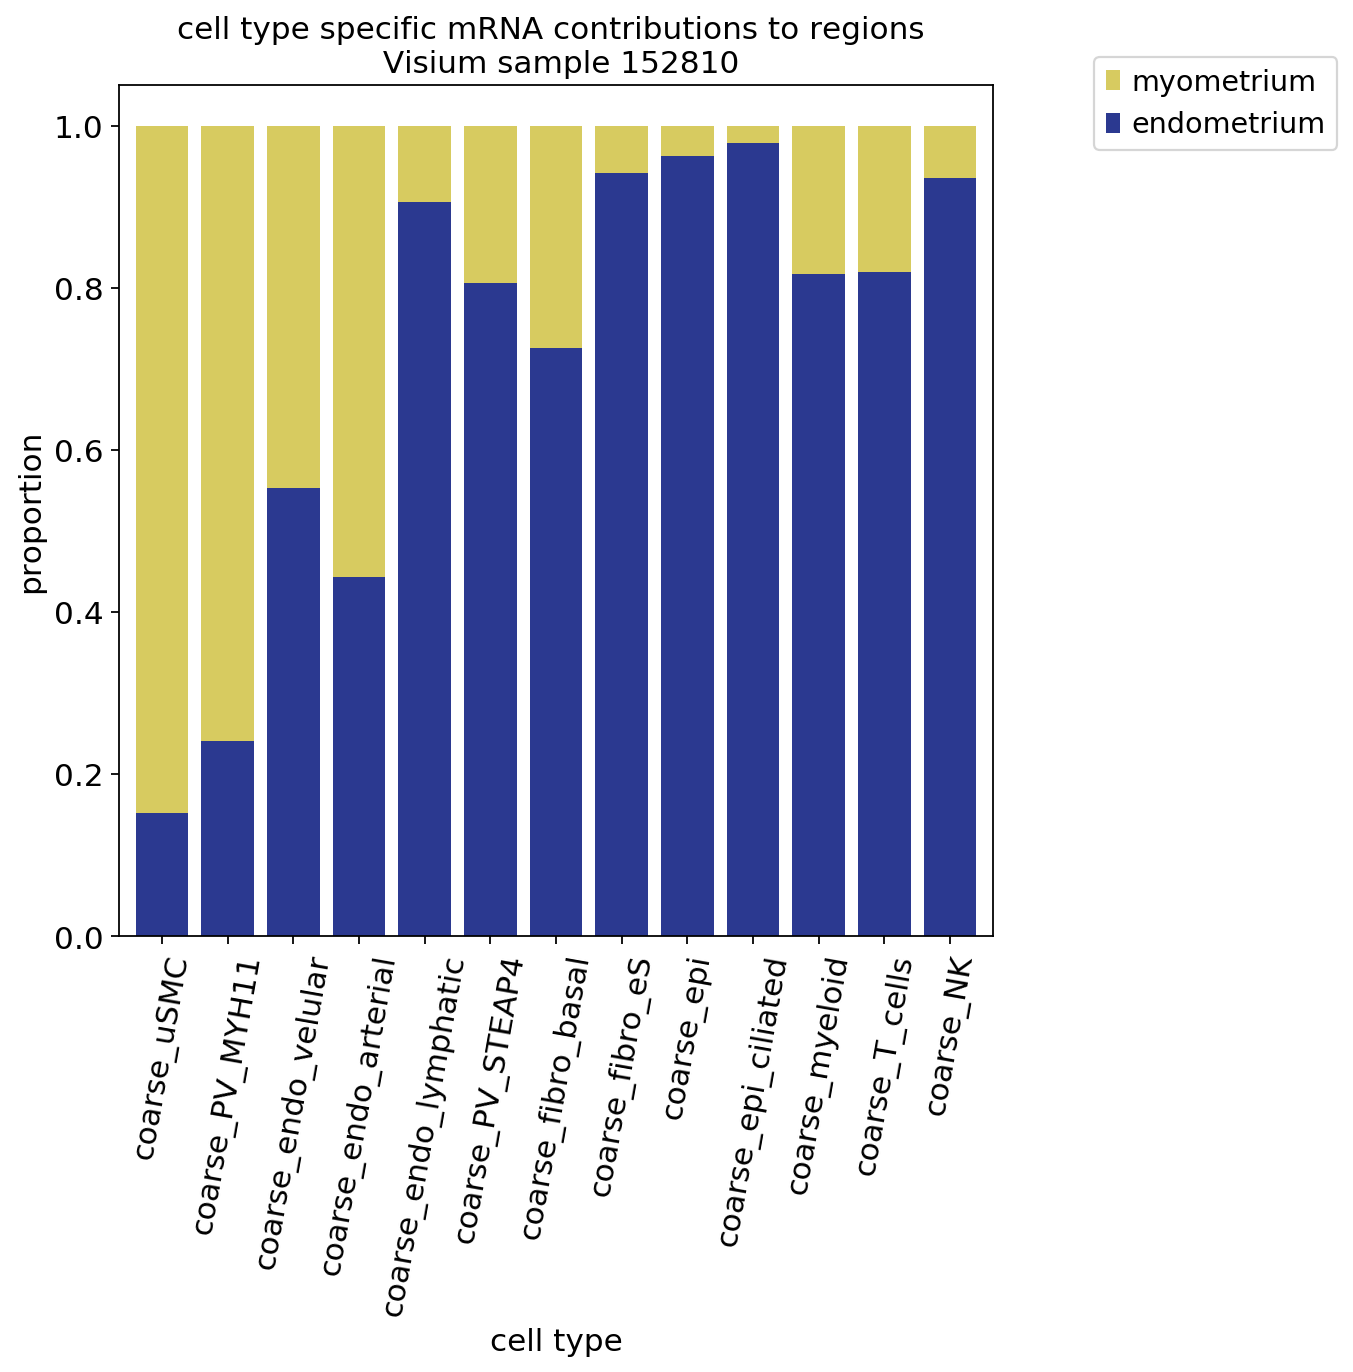

In [44]:
ax = clus_means['152810'].plot.bar(stacked=True, figsize=(7,7), width=0.8,
                                  color=('#2B3990','#D7CB60'))
#plt.legend()
handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles[::-1], labels[::-1], title='Line', loc='upper left')
ax.legend(handles[::-1],labels[::-1],
          bbox_to_anchor=(1.1, 1.05))
ax.tick_params(axis='x', rotation=80)

# to turn off the grid
plt.grid(b=None)

plt.title('cell type specific mRNA contributions to regions \n Visium sample 152810')
plt.ylabel('proportion')
plt.xlabel('cell type')

plt.savefig('./figures/Proportion_plots/152810_ct_mRNA_proportions_coarse_endo_myo.pdf',
           bbox_inches='tight')

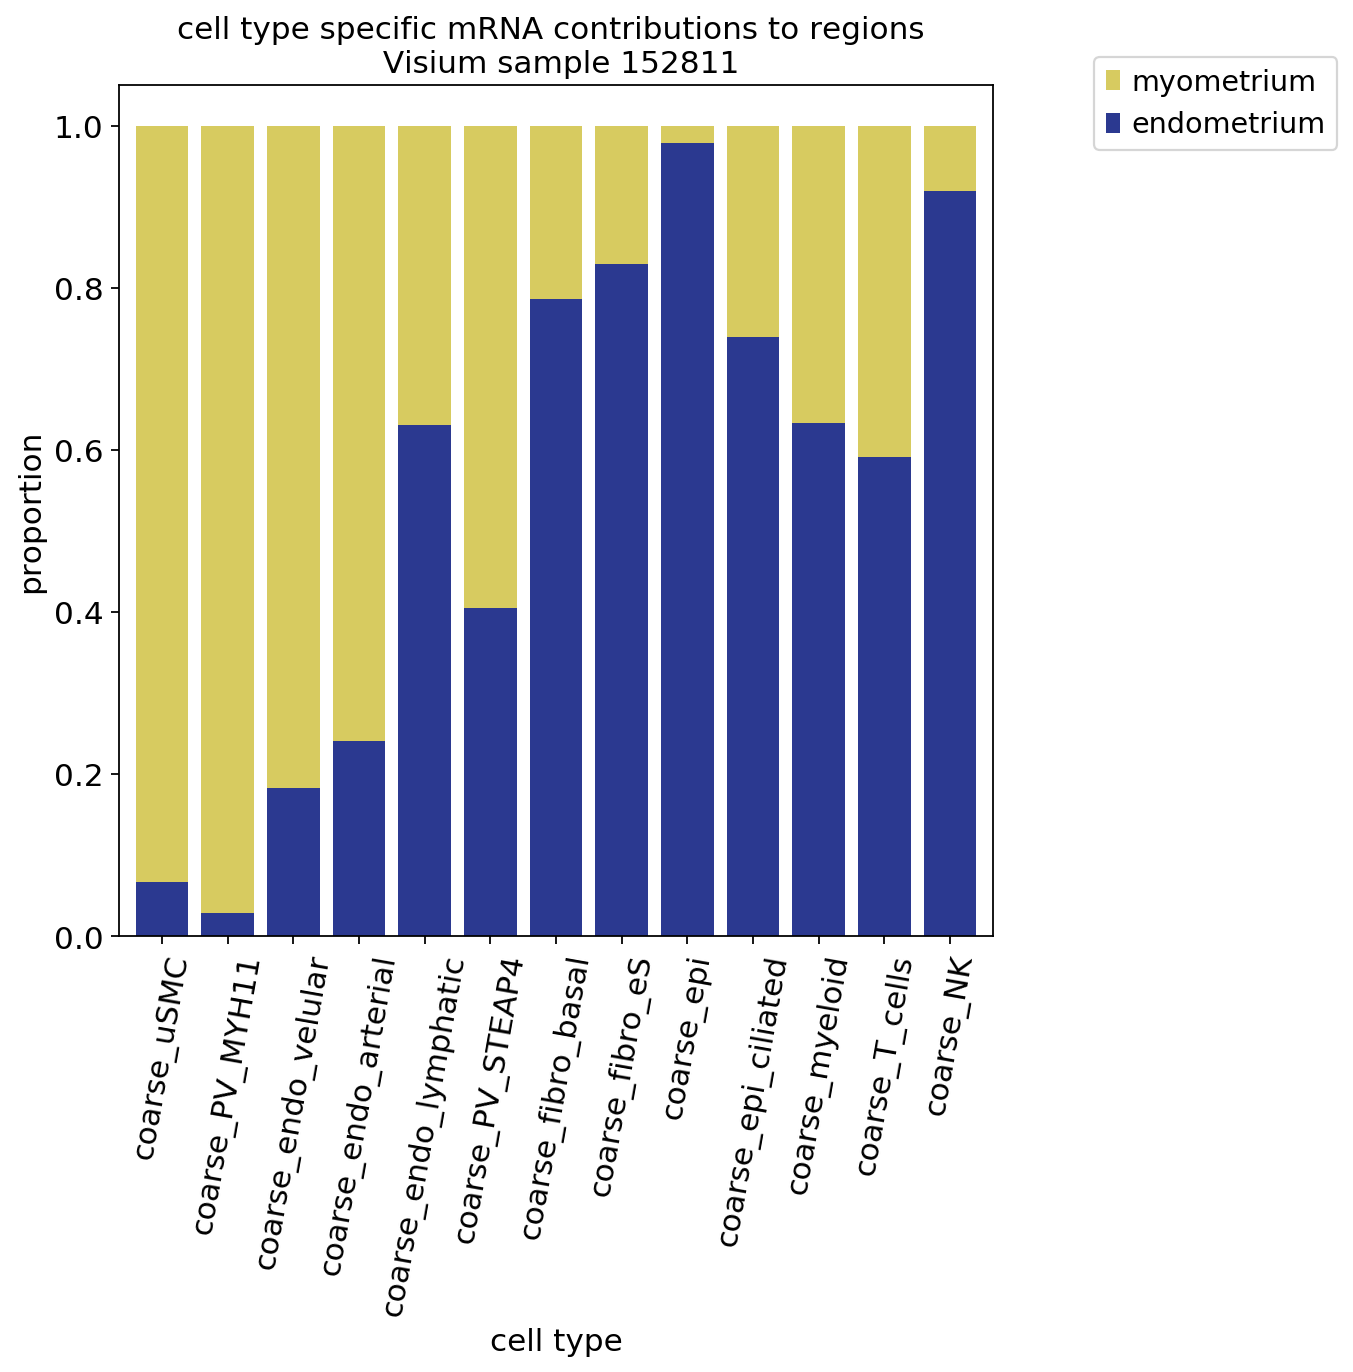

In [45]:
ax = clus_means['152811'].plot.bar(stacked=True, figsize=(7,7), width=0.8,
                                  color=('#2B3990','#D7CB60'))
#plt.legend()
handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles[::-1], labels[::-1], title='Line', loc='upper left')
ax.legend(handles[::-1],labels[::-1],
          bbox_to_anchor=(1.1, 1.05))
ax.tick_params(axis='x', rotation=80)

# to turn off the grid
plt.grid(b=None)

plt.title('cell type specific mRNA contributions to regions \n Visium sample 152811')
plt.ylabel('proportion')
plt.xlabel('cell type')

plt.savefig('./figures/Proportion_plots/152811_ct_mRNA_proportions_coarse_endo_myo.pdf',
           bbox_inches='tight')